[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/CryptoDataProcessing/blob/main/2_ohlc_exploration.ipynb)

### In this notebook, we TA analyzed features and divide them into groups that facilitate preprocessing.

In [1]:
import math
import time
from datetime import date
from os.path import join

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]

Loading the data prepared in the previous notebook, make sure that you have previously run binance_download notebook and saved the selected data.

In [3]:
DATA_DIR = "data"
SEQ_LEN = 30

START_DATE = date(2022, 4, 1)
END_DATE = date(2022, 4, 30)
PAIRS = ["ethusdt", "btcusdt", "bnbusdt", "dogeusdt", "ftmusdt", "ancusdt", "cakebusd"]
OHLC_INTERVALS = [20, 60, 120]

ohlc_dfs = [
    [
        [
            pd.read_csv(
                join(
                    DATA_DIR,
                    f"{pair}/ohlcvta_{pair}_{interval}_{OHLC_INTERVALS[0]*step}.csv",
                ),
                index_col="timestamp",
            )
            for step in range(interval // OHLC_INTERVALS[0])
        ]
        for interval in OHLC_INTERVALS
    ]
    for pair in PAIRS
]

In [4]:
pair_idx = PAIRS.index("ethusdt")
interval_idx = OHLC_INTERVALS.index(20)

ohlc_dfs[pair_idx][interval_idx][0].head(3)

,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-04-01 00:00:00,3281.51,3298.45,3272.47,3289.65,3285.904428,7891.0994,2.592940e+07,1.305524e+07,1.287416e+07,13804,...,NaN,NaN,NaN,3286.856667,NaN,3287.555,NaN,NaN,NaN,NaN
2022-04-01 00:20:00,3289.65,3298.58,3280.00,3297.93,3289.946648,5014.7985,1.649842e+07,7.372607e+06,9.125812e+06,9059,...,NaN,NaN,NaN,3288.921250,NaN,3293.610,NaN,NaN,NaN,NaN
2022-04-01 00:40:00,3297.92,3308.67,3296.81,3300.98,3302.346829,4483.7210,1.480680e+07,6.027491e+06,8.779311e+06,9084,...,NaN,NaN,NaN,3292.332996,NaN,3301.860,NaN,NaN,NaN,NaN


Some features, such as e.g. moving average, are not available in the first time steps, so when creating a dataset, we need to remove these features (however, almost every one has some startup period) or truncate the first n observations from the dataset.

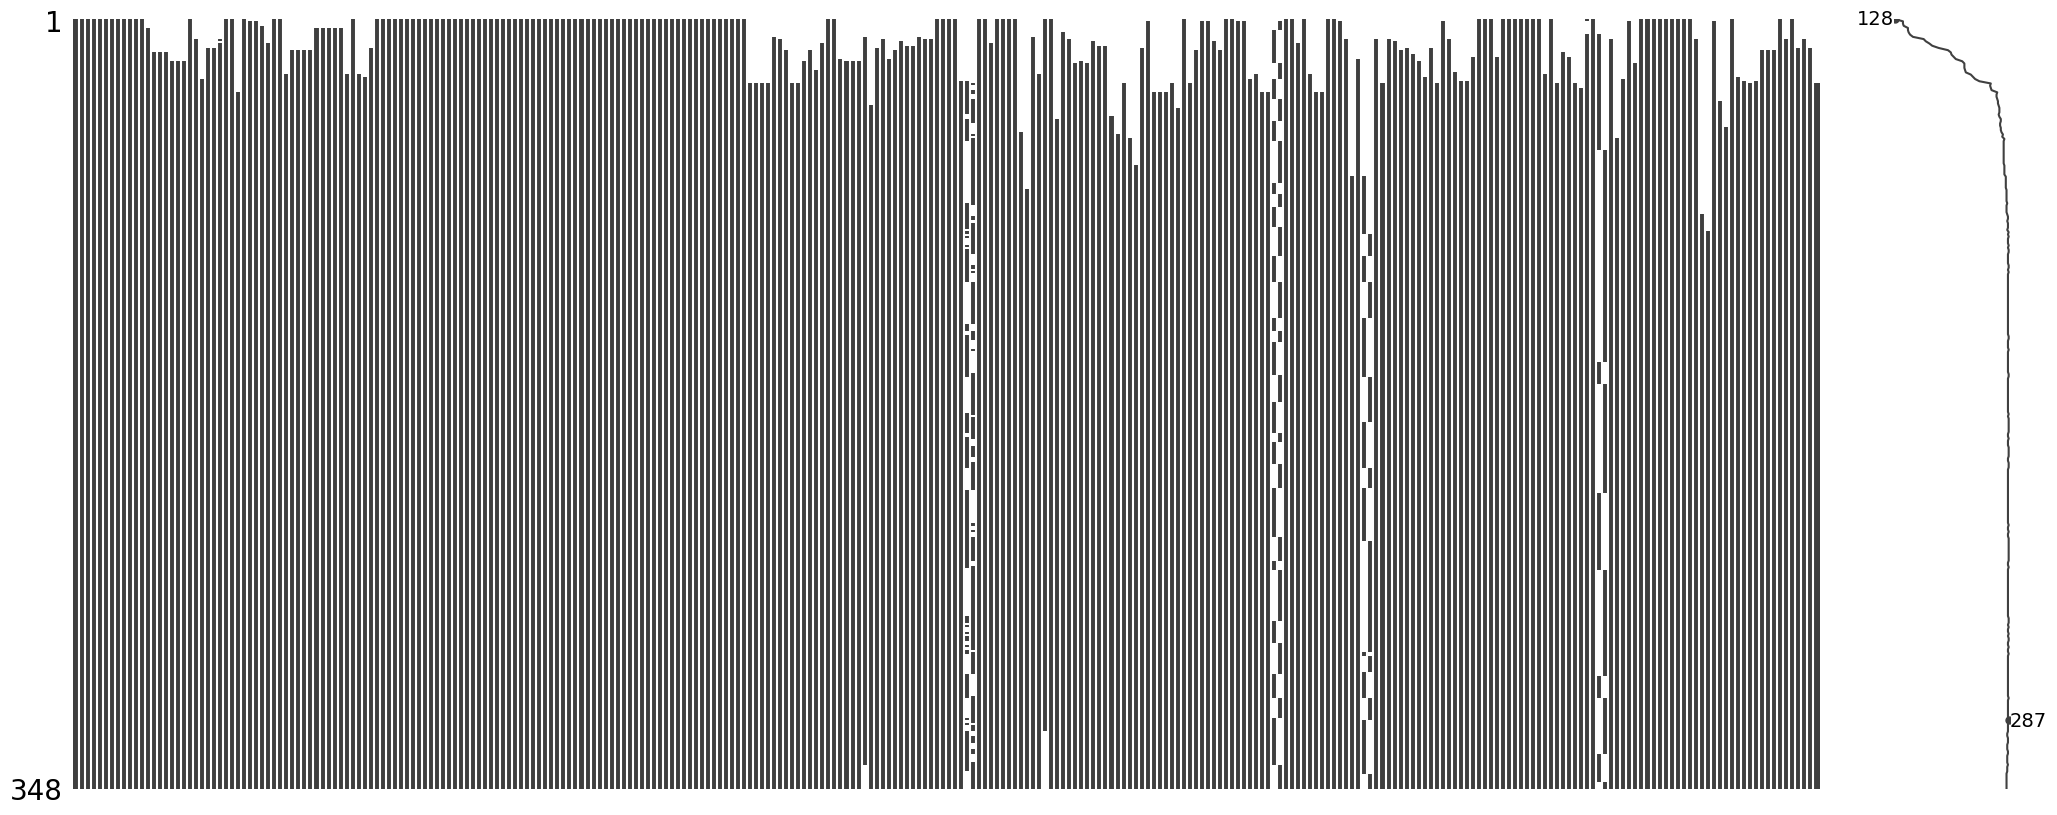

In [5]:
pair_idx = PAIRS.index("ethusdt")
interval_idx = OHLC_INTERVALS.index(120)

_ = msno.matrix(ohlc_dfs[pair_idx][interval_idx][0])

After discarding the first 50 missing values ​​the matrix is ​​much less jagged - almost all features have a calculated value from the initial time step

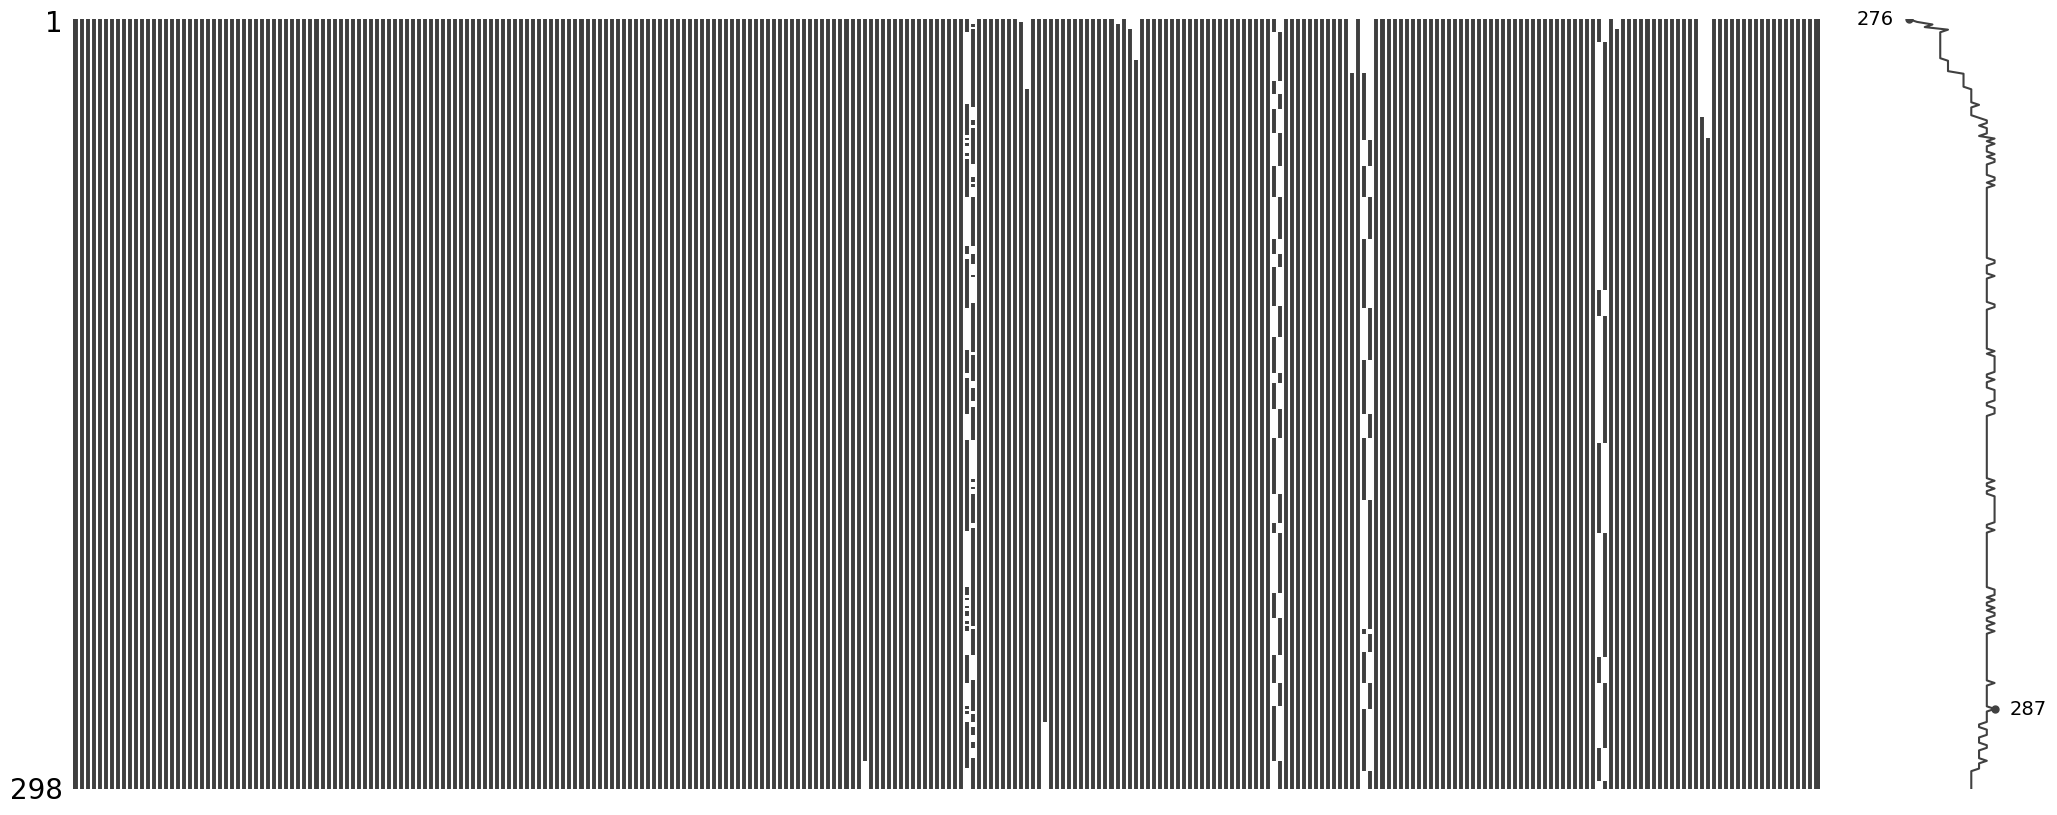

In [6]:
_ = msno.matrix(ohlc_dfs[pair_idx][interval_idx][0].iloc[50:])

It can be seen that we have 4 pairs of features that have gaps but fill each other. It is not a problem if we have identified them and apply the appropriate preprocessing. There are also features that are empty at the end of the dataset - we drop them out because they cannot be used in prediction (we will not know the value at time t = 0).

In [7]:
df = ohlc_dfs[0][0][0]
pair_features = []

for col in df:
    if df.iloc[200:][col].isna().sum():
        print(col, df.iloc[200:][col].isna().sum())
        if df.iloc[200:][col].isna().sum() >= 100:
            pair_features.append(col)

DPO_20 11
HILOl_13_21 731
HILOs_13_21 592
ICS_26 26
PSARl_0.02_0.2 946
PSARs_0.02_0.2 942
QQEl_14_5_4.236 857
QQEs_14_5_4.236 1031
SUPERTl_7_3.0 1037
SUPERTs_7_3.0 851


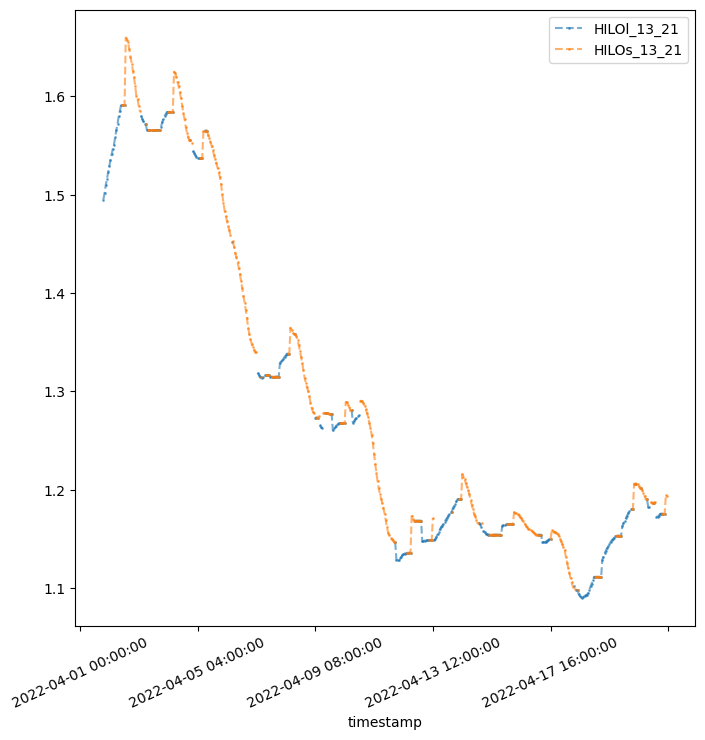

In [8]:
# Example of 'pair' features
ax = (
    ohlc_dfs[4][1][0]
    .iloc[:500][["HILOl_13_21", "HILOs_13_21"]]
    .plot(style="--o", markersize=1, alpha=0.6)
)
ax.tick_params(axis="x", labelrotation=25)

In [9]:
# We also want do identify and drop features that are empty on end of time series
ohlc_dfs[0][2][0][["CTI_12", "DPO_20", "ER_10", "ICS_26", "EOM_14_100000000"]].tail(5)

,CTI_12,DPO_20,ER_10,ICS_26,EOM_14_100000000
timestamp,,,,,
2022-04-29 14:00:00,-0.915702,NaN,0.527861,NaN,-6.231602e+05
2022-04-29 16:00:00,-0.915422,NaN,0.581514,NaN,-6.018955e+05
2022-04-29 18:00:00,-0.926134,NaN,0.642064,NaN,-7.105121e+05
2022-04-29 20:00:00,-0.944147,NaN,0.529749,NaN,-9.245753e+05
2022-04-29 22:00:00,-0.934187,NaN,0.458936,NaN,-1.088113e+06


In [10]:
# Remove columns that are not occur in all dataframes
columns_lists = []
for ohlc_pair in ohlc_dfs:
    for ohlc_interval in ohlc_pair:
        for df in ohlc_interval:
            columns_lists.append(df.columns.values)

all_columns = []
[all_columns.extend(cols) for cols in columns_lists]
all_columns = list(set(all_columns))

for ohlc_pair in ohlc_dfs:
    for ohlc_interval in ohlc_pair:
        for df in ohlc_interval:
            for col in df:
                if col not in all_columns:
                    df.pop(col)

We want to identify features that are monotonic, their value depends on the time interval for which we calculate the indicators, this makes them useless - they can have different values ​​for the same pair, the same datetime, differing only in the period of generating the OHLC dataframe. In the case of candle patterns, it may happen that in a given period there were only zero values, but the other features do not carry valuable information and should be removed.

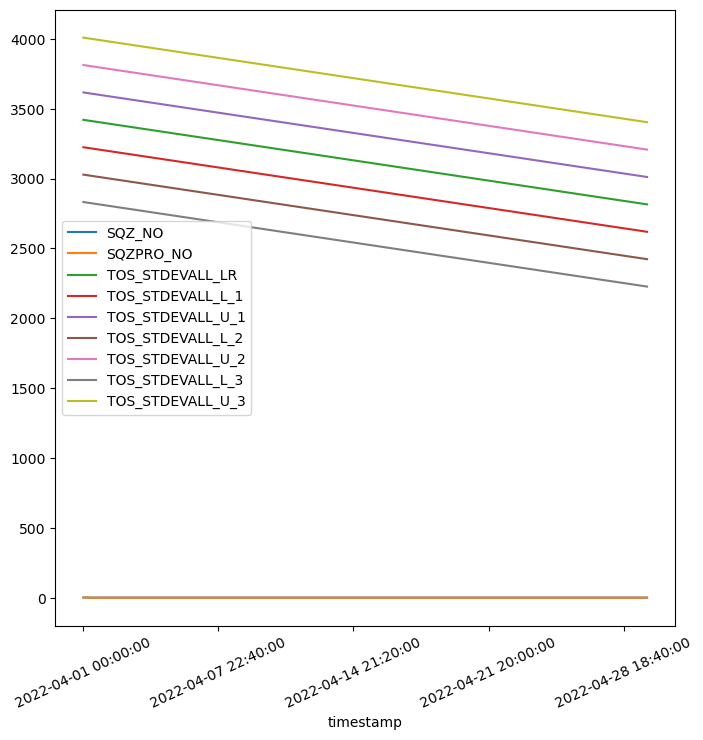

In [11]:
df = ohlc_dfs[0][0][0]
import matplotlib.ticker as ticker

monotonic_features = [
    col
    for col in df.columns.values
    if df[col].is_monotonic or df[col].is_monotonic_decreasing
]
monotonic_features = [m for m in monotonic_features if not m.startswith("CDL")]
ax = df[monotonic_features].plot()
ax.tick_params(axis="x", labelrotation=25)

Some features (such as, for example, moving averages) are strongly correlated with price. We want to identify them in order to apply a different preprocesing strategy to them (in terms of price). We can also easily identify candlestick patterns that we normalize differently (simply divide by 100 because the positive/negative signal is represented by the value +/- 100 and the other values are equal to zero).

In [12]:
# Depending on which column we choose as comparative, the results will differ slightly,
# it is most sensible to choose 'close' or 'weighted'
price_col = "close"
price_series = pd.concat(
    [
        pd.concat(
            [
                pd.concat([df[price_col] for df in ohlc_interval])
                for ohlc_interval in ohlc_pair
            ]
        )
        for ohlc_pair in ohlc_dfs
    ]
)

col_stats = {}
candle_features = []
for col in all_columns:
    if col.startswith("CDL_"):
        candle_features.append(col)
        continue
    col_series = pd.concat(
        [
            pd.concat(
                [
                    pd.concat([df[col] for df in ohlc_interval])
                    for ohlc_interval in ohlc_pair
                ]
            )
            for ohlc_pair in ohlc_dfs
        ]
    )
    col_stats[col] = {
        "mean": (col_series / price_series).mean(),
        "std": (col_series / price_series).std(),
    }

During the analyzes, I decided that the best indicator to determine if a feature is related to a price will be to check the mean and standard deviation of the feature divided by the price (ideally the average should be 1 and the deviation 0).
The threshold level is selected on a discretionary basis, however, it is possible to use graphs containing features for a certain threshold value, as well as we can observe the increase in the number of features with the increase of the threshold level.

Text(0, 0.5, 'Number of features')

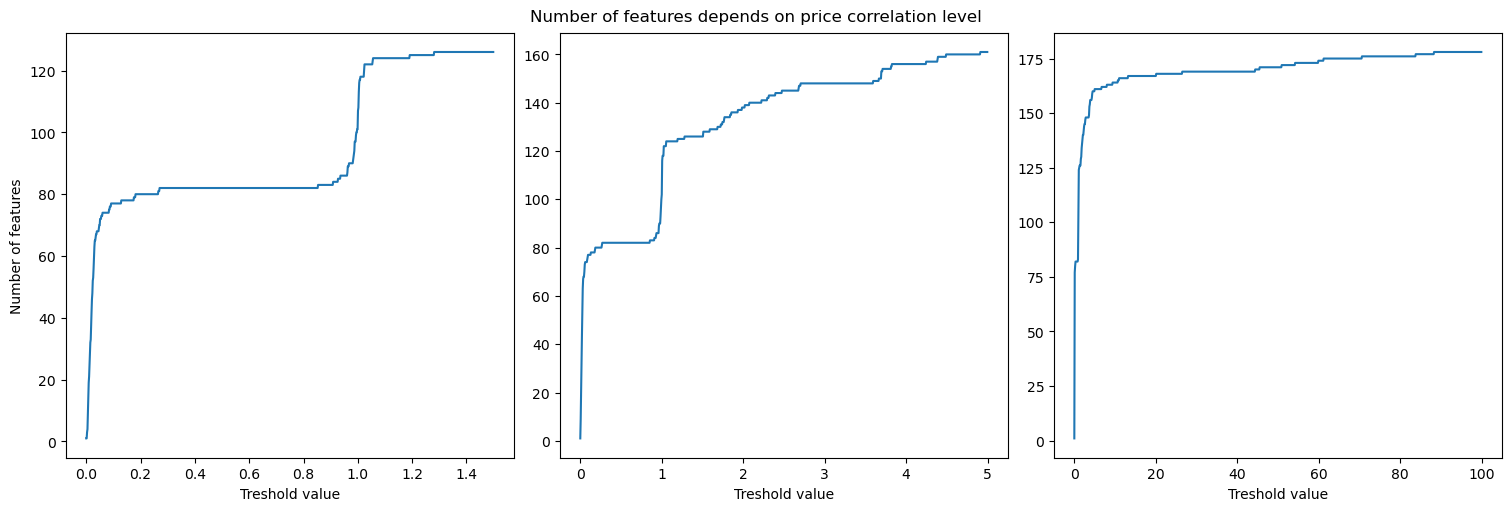

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
fig.suptitle("Number of features depends on price correlation level")
for ax, median_radius in zip(axs.flat, [1.5, 5, 100]):
    threshold_levels = np.arange(0, median_radius, median_radius / 1000)
    features_n = [
        len(
            [
                col
                for col in col_stats.keys()
                if abs(col_stats[col]["mean"] - 1) <= price_treshold
                and col_stats[col]["std"] <= price_treshold
            ]
        )
        for price_treshold in threshold_levels
    ]

    ax.plot(threshold_levels, features_n)
    ax.set_xlabel("Treshold value")
axs[0].set_ylabel("Number of features")

It is easy to notice the clustering of this data, a lot of features are caught below the threshold of about 0.3 and almost to the value of 0.8 there are no new features. Let's show them on the charts.

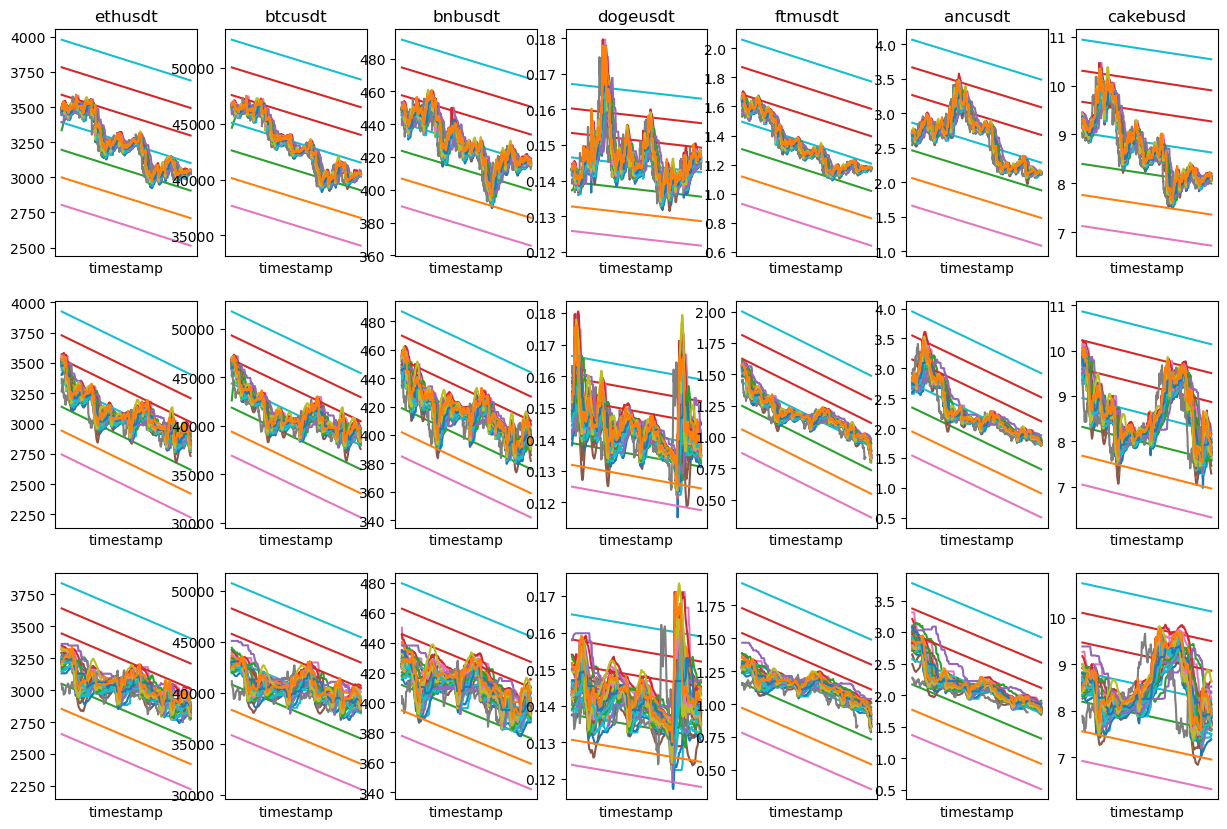

In [14]:
price_treshold = (
    0.55  # chosen as a middle value between 0.3 and 0.8 where we have no new features
)
price_features = [
    col
    for col in col_stats.keys()
    if abs(col_stats[col]["mean"] - 1) <= price_treshold
    and col_stats[col]["std"] <= price_treshold
]

fig, axs = plt.subplots(len(OHLC_INTERVALS), len(PAIRS), figsize=(15, 10))
for i, pair in enumerate(PAIRS):
    axs[0, i].set_title(pair)
    for j, interval in enumerate(OHLC_INTERVALS):
        ohlc_dfs[i][j][0].iloc[100:1100][price_features].plot(
            ax=axs[j, i], legend=False
        )
        axs[j, i].tick_params(
            axis="both", which="both", bottom=False, top=False, labelbottom=False
        )

In [15]:
means = [abs(value["mean"]) for col, value in col_stats.items()]
print(
    f"""Some features, e.g. those more related to volume, may have radically different mean values in relation to prices,
      max: {max(means)}, min: {min(means)}"""
)

Some features, e.g. those more related to volume, may have radically different mean values in relation to prices,
      max: 5875750115.012377, min: 0.0001622566229199671


Some features have only binary or (-1, 0, 1) values - let's extract them.

In [16]:
zero_one_features = [
    f
    for f in all_columns
    if all(
        [
            f not in features
            for features in [monotonic_features, pair_features, candle_features]
        ]
    )
    and df[f].isin([-1, 0, 1]).all()
]

Summing up, we distinguished monotone features (we drop them), features of candlestick patterns, features strongly related to price (including several pairs of features that contain gaps but complement each other), features that always take the value -1, 0 or 1 and other features (which do not match the previous groups) - for them in the next notebook we present appropriate preprocessing with the use of power transform.

In [17]:
print(f"number of monotonic features: {len(monotonic_features)}")
print(monotonic_features)

number of monotonic features: 9
['SQZ_NO', 'SQZPRO_NO', 'TOS_STDEVALL_LR', 'TOS_STDEVALL_L_1', 'TOS_STDEVALL_U_1', 'TOS_STDEVALL_L_2', 'TOS_STDEVALL_U_2', 'TOS_STDEVALL_L_3', 'TOS_STDEVALL_U_3']


In [18]:
print(f"number of pair features: {len(pair_features)}")
print(pair_features)

number of pair features: 8
['HILOl_13_21', 'HILOs_13_21', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'SUPERTl_7_3.0', 'SUPERTs_7_3.0']


In [19]:
print(f"number of candle features: {len(candle_features)}")
print(candle_features)

number of candle features: 62
['CDL_3LINESTRIKE', 'CDL_MORNINGDOJISTAR', 'CDL_HARAMICROSS', 'CDL_INNECK', 'CDL_GAPSIDESIDEWHITE', 'CDL_SHORTLINE', 'CDL_ADVANCEBLOCK', 'CDL_ONNECK', 'CDL_CONCEALBABYSWALL', 'CDL_LADDERBOTTOM', 'CDL_GRAVESTONEDOJI', 'CDL_BELTHOLD', 'CDL_HARAMI', 'CDL_LONGLINE', 'CDL_2CROWS', 'CDL_UNIQUE3RIVER', 'CDL_3STARSINSOUTH', 'CDL_INVERTEDHAMMER', 'CDL_RICKSHAWMAN', 'CDL_PIERCING', 'CDL_MATCHINGLOW', 'CDL_DRAGONFLYDOJI', 'CDL_LONGLEGGEDDOJI', 'CDL_BREAKAWAY', 'CDL_THRUSTING', 'CDL_INSIDE', 'CDL_HAMMER', 'CDL_DOJI_10_0.1', 'CDL_EVENINGSTAR', 'CDL_SEPARATINGLINES', 'CDL_HIKKAKE', 'CDL_DOJISTAR', 'CDL_RISEFALL3METHODS', 'CDL_KICKINGBYLENGTH', 'CDL_CLOSINGMARUBOZU', 'CDL_MORNINGSTAR', 'CDL_DARKCLOUDCOVER', 'CDL_MATHOLD', 'CDL_HIKKAKEMOD', 'CDL_XSIDEGAP3METHODS', 'CDL_3OUTSIDE', 'CDL_STALLEDPATTERN', 'CDL_ABANDONEDBABY', 'CDL_TAKURI', 'CDL_STICKSANDWICH', 'CDL_SHOOTINGSTAR', 'CDL_3WHITESOLDIERS', 'CDL_HANGINGMAN', 'CDL_UPSIDEGAP2CROWS', 'CDL_3INSIDE', 'CDL_3BLACKCROWS', 

In [20]:
print(f"number of zero one features: {len(zero_one_features)}")
print(zero_one_features)

number of zero one features: 17
['THERMOs_20_2_0.5', 'AOBV_SR_2', 'SQZPRO_OFF', 'SUPERTd_7_3.0', 'SQZPRO_ON_WIDE', 'DEC_1', 'SQZPRO_ON_NORMAL', 'SQZ_OFF', 'AMATe_SR_8_21_2', 'INC_1', 'PSARr_0.02_0.2', 'SQZPRO_ON_NARROW', 'AMATe_LR_8_21_2', 'SQZ_ON', 'THERMOl_20_2_0.5', 'TTM_TRND_6', 'AOBV_LR_2']


In [21]:
price_features = [
    f for f in price_features if f not in monotonic_features and f not in pair_features
]
price_features = [
    f
    for f in price_features
    if all(
        [
            f not in features
            for features in [
                monotonic_features,
                pair_features,
                candle_features,
                zero_one_features,
            ]
        ]
    )
]
print(f"number of price features: {len(price_features)}")
print(price_features)

number of price features: 69
['HMA_10', 'QTL_30_0.5', 'high', 'SSF_10_2', 'HWL', 'ABER_SG_5_15', 'PWMA_10', 'JMA_7_0', 'FWMA_10', 'VIDYA_14', 'DEMA_10', 'RMA_10', 'SINWMA_14', 'BBM_5_2.0', 'open', 'DCL_20_20', 'BBL_5_2.0', 'SUPERT_7_3.0', 'KCBe_20_2', 'CKSPs_10_3_20', 'HL2', 'MIDPOINT_2', 'WMA_10', 'HWMA_0.2_0.1_0.1', 'MIDPRICE_2', 'ACCBL_20', 'HLC3', 'SMA_10', 'ZL_EMA_10', 'ACCBM_20', 'HWM', 'DCU_20_20', 'MCGD_10', 'ALMA_10_6.0_0.85', 'HA_close', 'DCM_20_20', 'SWMA_10', 'T3_10_0.7', 'ACCBU_20', 'OHLC4', 'close', 'KCUe_20_2', 'HA_low', 'LR_14', 'HA_open', 'WCP', 'ISA_9', 'CKSPl_10_3_20', 'ABER_ZG_5_15', 'ICS_26', 'low', 'KCLe_20_2', 'VWMA_10', 'ABER_XG_5_15', 'HA_high', 'ISB_26', 'TRIMA_10', 'VWAP_D', 'HWU', 'ITS_9', 'MEDIAN_30', 'EMA_10', 'LDECAY_5', 'weighted', 'KAMA_10_2_30', 'TEMA_10', 'HILO_13_21', 'IKS_26', 'BBU_5_2.0']


In [22]:
other_features = [
    f
    for f in all_columns
    if all(
        [
            f not in features
            for features in [
                monotonic_features,
                pair_features,
                candle_features,
                price_features,
                zero_one_features,
            ]
        ]
    )
]
print(f"number of other features: {len(other_features)}")
print(other_features)

number of other features: 125
['ADOSC_3_10', 'STC_10_12_26_0.5', 'UO_7_14_28', 'VTXP_14', 'NATR_14', 'MACD_12_26_9', 'SMIo_5_20_5', 'VAR_30', 'ROC_10', 'BEARP_13', 'EFI_13', 'CMF_20', 'OBV_max_2', 'BBB_5_2.0', 'J_9_3', 'NVI_1', 'MACDh_12_26_9', 'TSI_13_25_13', 'PDIST', 'THERMO_20_2_0.5', 'ATRr_14', 'AR_26', 'PPOh_12_26_9', 'PVOs_12_26_9', 'KVOs_34_55_13', 'OBV_min_2', 'OBVe_4', 'PVT', 'TRIXs_30_9', 'MASSI_9_25', 'RVGIs_14_4', 'RVI_14', 'PVOL', 'KSTs_9', 'RSX_14', 'BBP_5_2.0', 'trades_full', 'SKEW_30', 'SMI_5_20_5', 'STOCHd_14_3_3', 'VHF_28', 'MOM_10', 'TRIX_30_9', 'ADX_14', 'KST_10_15_20_30_10_10_10_15', 'BIAS_SMA_26', 'MACDs_12_26_9', 'UI_14', 'EBSW_40_10', 'STCstoch_10_12_26_0.5', 'DPO_20', 'BR_26', 'CTI_12', 'ABER_ATR_5_15', 'D_9_3', 'APO_12_26', 'CFO_9', 'SQZ_20_2.0_20_1.5', 'THERMOma_20_2_0.5', 'volume_asset_buyer_maker', 'VTXM_14', 'STOCHRSIk_14_14_3_3', 'ENTP_10', 'DMP_14', 'AROOND_14', 'close_Z_30_1', 'PSL_12', 'volume_asset', 'PCTRET_1', 'PPO_12_26_9', 'QS_10', 'SLOPE_1', 'KUR